# Experimental FLD scoring 

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

from peakqc.fld_scoring import *
import peakqc.insertsizes as ins

In [2]:
fragments_file = "/mnt/workspace2/jdetlef/data/public_data/fragments_heart_left_ventricle_194_sorted.bed"
h5ad_file = "/mnt/workspace2/jdetlef/data/public_data/heart_lv_SM-JF1NY.h5ad"
bamfile = "/mnt/workspace2/jdetlef/data/public_data/sorted_heart_left_ventricle_194.bam"

In [3]:
fragments_file='/mnt/workspace2/jdetlef/repos/PEAK_QC/tests/data/insertsizes_related/fragments_heart_left_ventricle_head_100k.bed'
h5ad_file = '/mnt/workspace2/jdetlef/repos/PEAK_QC/tests/data/fld_scoring_related/subsetted_adata.h5ad'
bamfile = '/mnt/workspace2/jdetlef/repos/PEAK_QC/tests/data/insertsizes_related/heart_left_ventricle_1mio.bam'

In [4]:
#fragments_file = "/mnt/workspace2/jdetlef/repos/PEAK_QC/tests/data/fld_scoring_related/mm10_atac_fragments.bed"
#bamfile = "/mnt/workspace2/jdetlef/repos/PEAK_QC/tests/data/fld_scoring_related/mm10_atac.bam"
#h5ad_file = "/mnt/workspace2/jdetlef/repos/PEAK_QC/tests/data/fld_scoring_related/mm10_atac.h5ad"

In [5]:
barcodes = adata.obs.index.to_list()

NameError: name 'adata' is not defined

In [6]:
adata = sc.read_h5ad(h5ad_file)
adata_f = adata.copy()
adata_b = adata.copy()

In [ ]:
adata = sc.read_h5ad(h5ad_file)
adata_barcodes = adata.obs.index.tolist()

# split index for barcodes CBs
barcodes = []
for entry in adata_barcodes:
    barcode = entry.split('+')[1]
    barcodes.append(barcode)

In [ ]:
adata.obs['stripped_barcodes'] = barcodes
adata.obs = adata.obs.set_index('stripped_barcodes')
adata_f = adata.copy()
adata_b = adata.copy()

In [ ]:
adata.var

In [ ]:
chr_list = adata.var['Chromosome'].unique().to_list()

In [ ]:
chr_list

In [ ]:
subset = ['chr1',
          'chr2']

In [ ]:
adata_subset = adata[:, adata.var['Chromosome'].isin(subset)].copy()

In [ ]:
adata_subset.write('subsetted_adata.h5ad')

In [ ]:
adata_subset.obs

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 1it [00:00,  9.45it/s]


Done reading file - elapsed time: 0:00:01
Converting counts to dataframe...
Done getting insertsizes from fragments!
plotting density...


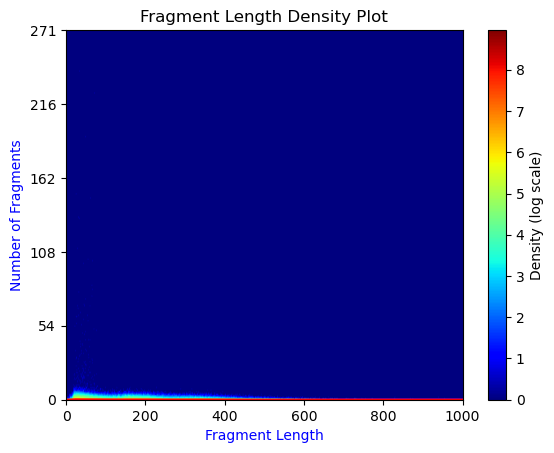

calculating scores using the custom continues wavelet transformation...


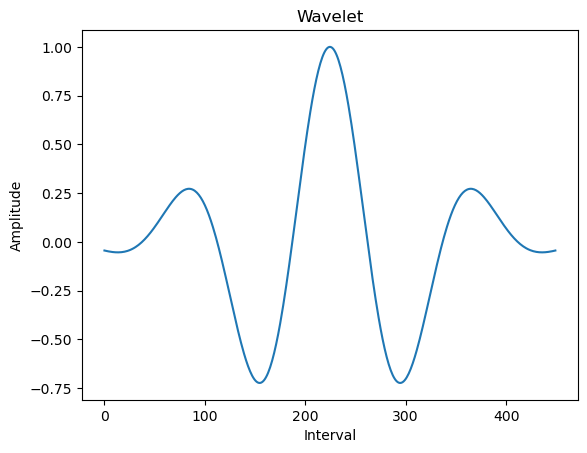

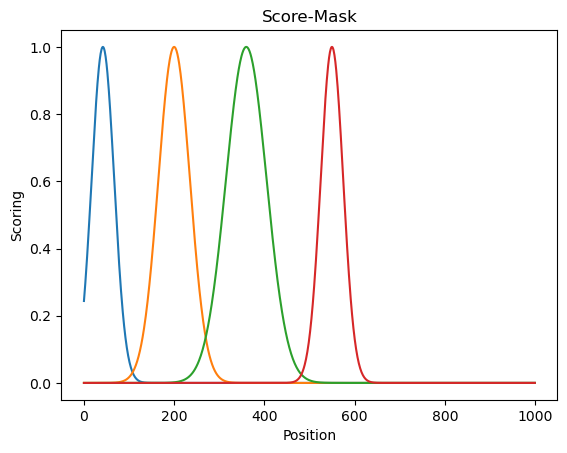

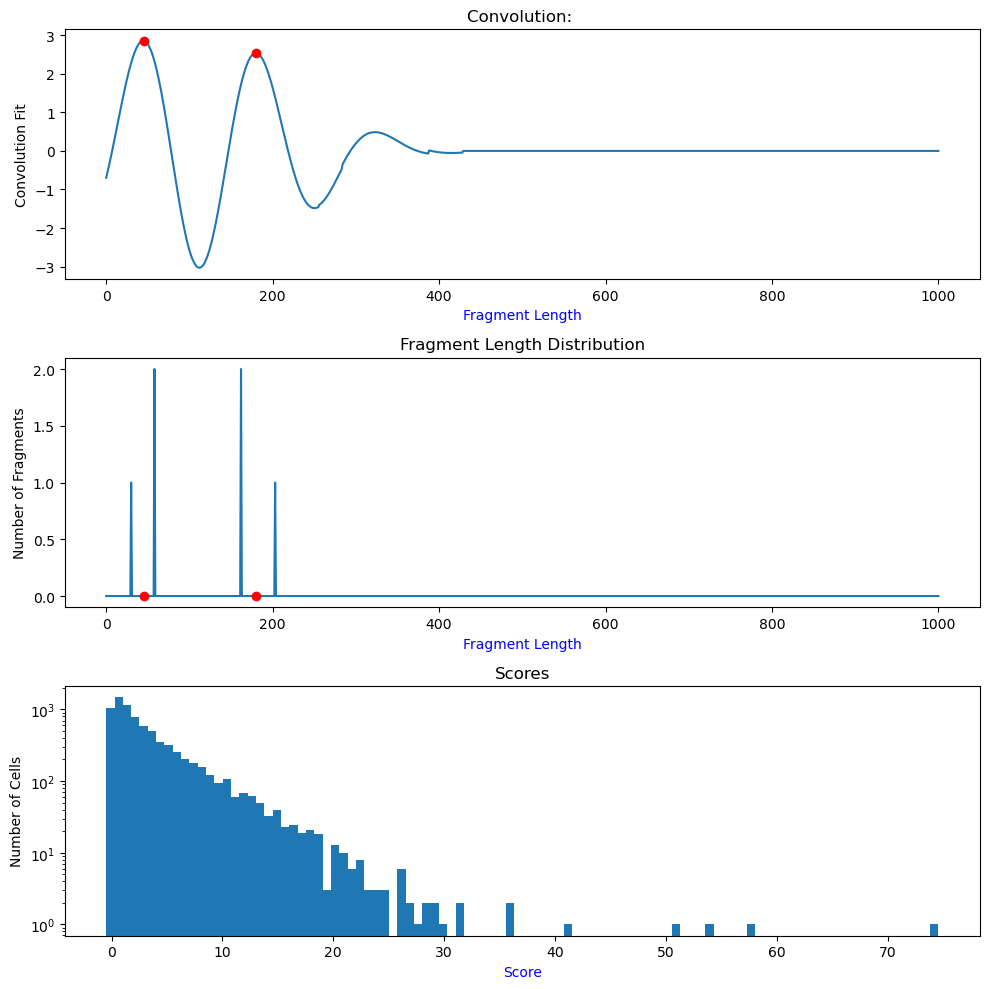

In [7]:
adata_f = add_fld_metrics(adata=adata_f,
                        fragments=fragments_file,
                        barcode_col=None,
                        chunk_size_fragments=5000000,
                        peaks_thr=0.5,
                        wavelength=150,
                        sigma=0.4,
                        plot=True,
                        save_density=None,
                        save_overview=None,
                        sample=0,
                        n_threads=12)

In [8]:
adata_f.obs

,logUMI,tsse,tissue,cell type,Life stage,closest Cell Ontology term(s),Cell Ontology ID,fld_score,mean_fragment_size,n_fragments
stripped_barcodes,,,,,,,,,,
TAGTGCTGTCTCGCTTAGCCTT,3.103119,15.499255,heart_lv_SM-JF1NY,Naive T cell,Adult,naive t cell,CL:0000898,0.000000,0.00,0.0
AAATCCGCATAACCGCTAATGA,3.395326,10.463122,heart_lv_SM-JF1NY,Macrophage (General),Adult,macrophage,CL:0000235,0.123823,51.00,3.0
AAATCCGCATACCAATCGCTTG,3.523876,13.254036,heart_lv_SM-JF1NY,Macrophage (General),Adult,macrophage,CL:0000235,0.205305,58.25,4.0
AAATCCGCATACGCGGTATGTA,3.231979,10.817031,heart_lv_SM-JF1NY,Macrophage (General),Adult,macrophage,CL:0000235,0.677154,161.00,1.0
AAATCCGCATATTAGGAGGTCT,3.202488,10.634648,heart_lv_SM-JF1NY,Macrophage (General),Adult,macrophage,CL:0000235,0.026425,100.50,2.0
...,...,...,...,...,...,...,...,...,...,...
TACCGTACCTCAGACCTGCTCA,3.558709,9.710744,heart_lv_SM-JF1NY,Pericyte (General) 2,Adult,pericyte cell,CL:0000669,0.019635,139.00,1.0
TAGACCAGGGCTTGCTGCCTAT,4.027431,7.671653,heart_lv_SM-JF1NY,Pericyte (General) 2,Adult,pericyte cell,CL:0000669,5.261129,140.45,27.0
TATGTATGGCTTAGCTTCTCTG,3.456062,16.223776,heart_lv_SM-JF1NY,Pericyte (General) 2,Adult,pericyte cell,CL:0000669,3.039723,138.71,6.0


Opening bam file...
Creating chunks of size 1000000bp...
Counting insertsizes across 3103 chunks...


100%|██████████| 3103/3103 [00:04<00:00, 707.40it/s]


Done reading file - elapsed time: 0:00:04
Converting counts to dataframe...
Done getting insertsizes from fragments!
plotting density...


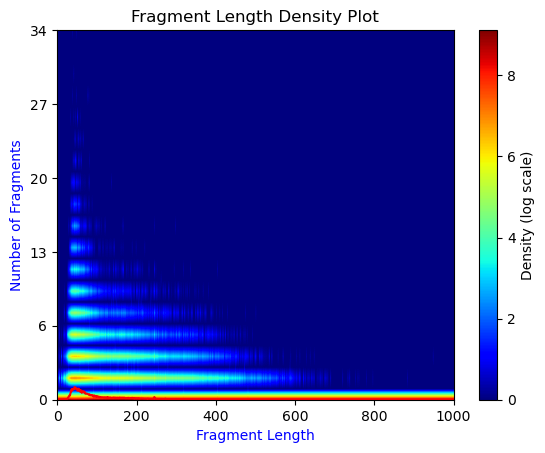

calculating scores using the custom continues wavelet transformation...


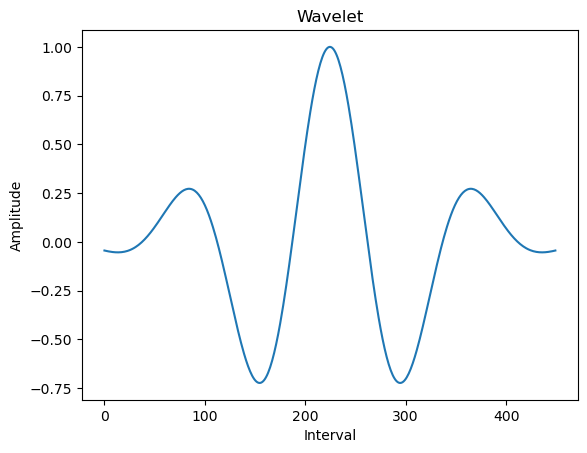

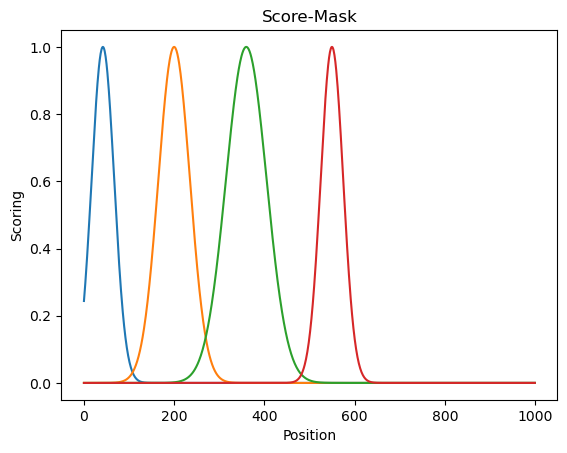

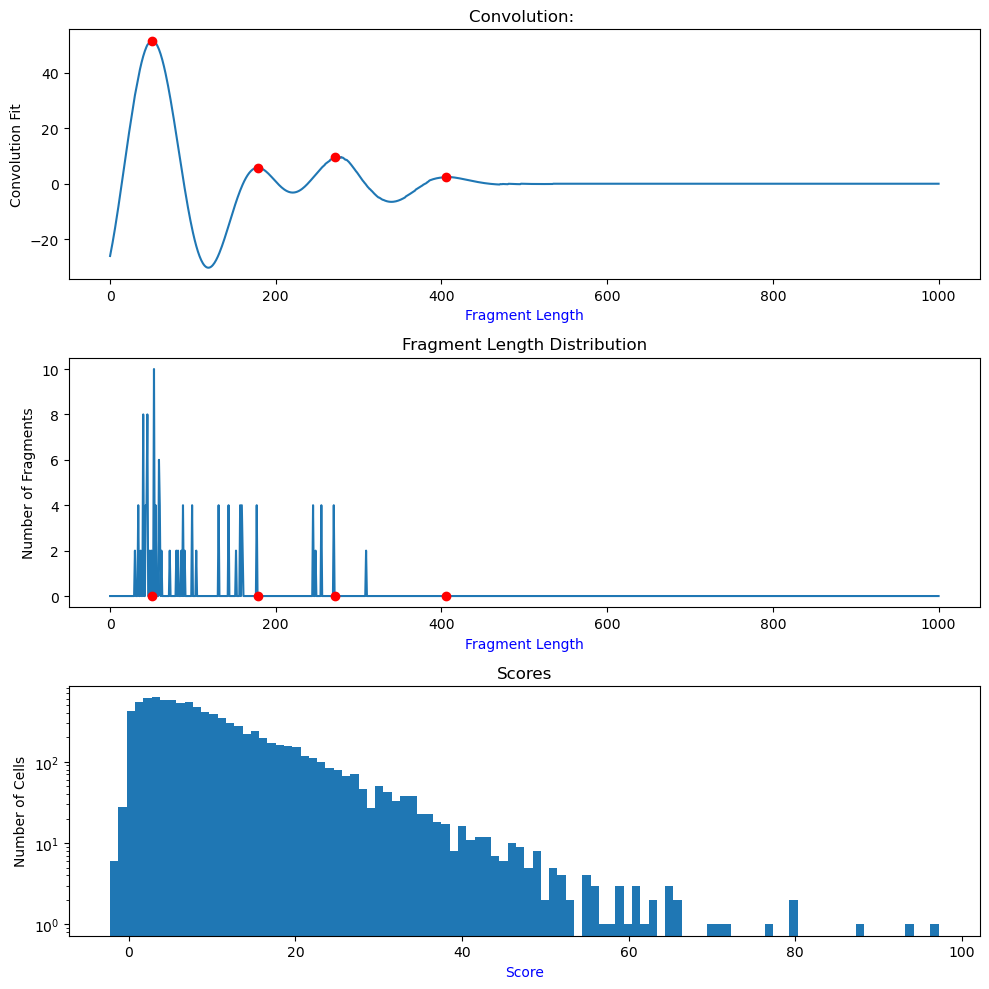

In [9]:
adata_b = add_fld_metrics(adata=adata_b,
                        bam=bamfile,
                        barcode_col=None,
                        barcode_tag="CB",
                        chunk_size_bam=1000000,
                        regions=None,
                        peaks_thr=0.5,
                        wavelength=150,
                        sigma=0.4,
                        plot=True,
                        save_density=None,
                        save_overview=None,
                        sample=0,
                        n_threads=12)

In [ ]:
adata_b.obs

In [ ]:

def good_modulation():
    """Create a modulation curve."""

    mus = [45, 200, 360]
    sigs = [45, 55, 100]
    divs = [1, 2, 6]

    return modulation(mus, sigs, divs)



def bad_modulation():
    """Create a modulation curve."""

    mus = [45, 100, 360]
    sigs = [45, 80, 100]
    divs = [1, 8, 10]

    return modulation(mus, sigs, divs)


def modulation(mus, sigs, divs):
    """Build a modulation curve."""
    def gaussian(x, mu, sig):  # Gaussian function
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    curves = []
    x_values = np.linspace(0, 1000, 1000)
    for mu, sig in [(mus[0], sigs[0]), (mus[1], sigs[1]), (mus[2], sigs[2])]:  # Gaussian curves with different means and standard deviations
        curves.append(gaussian(x_values, mu, sig))

    curves[1] = curves[1] / divs[0]  # Peak 1
    curves[1] = curves[1] / divs[1] # Peak 2
    curves[2] = curves[2] / divs[2]  # Bias
    sum_c = np.sum(curves, axis=0)  # Sum of the curves

    return (sum_c * 100)

In [ ]:
good_modulation = good_modulation()

plt.plot(good_modulation)

In [ ]:
bad_modulation = bad_modulation()

plt.plot(bad_modulation)

In [ ]:
good_fit = custom_conv(np.array([good_modulation]))
good_peaks = call_peaks(good_fit)
good_peaks = filter_peaks(good_peaks, reference=good_fit, peaks_thr=150, operator="bigger")
good_score = score_mask(good_peaks, good_fit)
bad_fit = custom_conv([bad_modulation])
bad_peaks = call_peaks(bad_fit)
bad_peaks = filter_peaks(bad_peaks, reference=bad_fit, peaks_thr=150, operator="bigger")
bad_score = score_mask(bad_peaks, bad_fit)

In [ ]:
good_score

In [ ]:
bad_score

In [ ]:
good_peaks

In [ ]:
good_peaks

In [ ]:
plt.plot(bad_fit[0])

In [ ]:
peaks

In [ ]:
round(wav_1[peaks_1[0][0]] / wav_1[peaks_1[0][1]], 1) == 1

In [ ]:
round(wav_2[peaks_2[0][0]] / wav_2[peaks_2[0][1]], 1) == 0.3

In [ ]:
# check for the correct wavelength
wav_1 = cos_wavelet(wavelength=100,
                amplitude=1.0,
                phase_shift=0,
                mu=0.0,
                sigma=10,
                plot=False,
                save=None) 

peaks_1 = call_peaks([wav_1])

99 == peaks_1[0][1] - peaks_1[0][0]
100 == peaks_1[0][2] - peaks_1[0][1]

# check if centered
wav_2 = cos_wavelet(wavelength=100,
                amplitude=1.0,
                phase_shift=0,
                mu=0.0,
                sigma=0.4,
                plot=False,
                save=None) 

peaks_2 = call_peaks([wav_2])
np.where(np.max(wav_2) == wav_2)[0][0] == 149 # check if centered

# check if sigma scales the cosine 
round(wav_1[peaks_1[0][0]] / wav_1[peaks_1[0][1]], 1) == 1
round(wav_2[peaks_2[0][0]] / wav_2[peaks_2[0][1]], 1) == 0.3

# check if its shifting
wav_3 = cos_wavelet(wavelength=100,
                amplitude=1.0,
                phase_shift=np.pi,
                mu=0.0,
                sigma=10,
                plot=False,
                save=None) 

peaks_3 = call_peaks([wav_3])
np.where(np.max(wav_3) == wav_3)[0][0] == 100  # half the wavelength shift compared to before


wav_4 = cos_wavelet(wavelength=100,
                amplitude=1.0,
                phase_shift=0,
                mu=100,
                sigma=0.4,
                plot=False,
                save=None) 

peaks_4 = call_peaks([wav_4])
np.where(np.max(wav_4) == wav_4)[0][0]  == 249  # one wavelength shift for the gauss curve compared to before

In [ ]:
wavelength = 100
wavl_scale = int(wavelength * 1.5)
x = np.linspace(-wavl_scale, wavl_scale, wavl_scale * 2)

In [ ]:
np.where(np.max(wav_3) == wav_3)[0]

In [ ]:
peaks_3[0][0] == 100
peaks_3[0][1] == 199

In [ ]:
plt.plot(wav_3)

In [ ]:
plt.plot(wav_2)

In [ ]:
len(cosine_curve)

In [ ]:
sigma = 0.4
mu = 0
gaussian = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
wavelet = cosine_curve * gaussian

In [ ]:
len(wav)

In [ ]:
len(gaussian)

In [ ]:
len(cosine_curve)

In [ ]:
x = np.linspace(-4, 4, 1000)
mu = 0
sig = 1
gaussian = gauss(x, mu, sig)
plt.plot(gaussian)
print(gaussian[350])
print(gaussian[499])
print(gaussian[650])

In [ ]:
    x = np.linspace(-4, 4, 1000)
    mu = 0
    sig = 1
    gauss = fld.gauss(x, mu, sig)

    assert gauss[200] < 0.1
    assert gauss[500] == 1
    assert gauss[800] < 0.1

In [ ]:
@beartype
def gauss(x: npt.ArrayLike,
          mu: int | float,
          sigma: int | float) -> npt.ArrayLike:
    """
    Calculate the values of the Gaussian function for a given x, mu and sigma.

    Parameters
    ----------
    x : npt.ArrayLike
        x values
    mu : float
        mu value
    sigma : float
        sigma value

    Returns
    -------
    float
        Value of the Gaussian function for the given x, mu and sigma.
    """

    gaussian = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    
    # scale max to 1
    max_val = np.max(gaussian)
    scaler = 1/max_val
    gaussian = gaussian * scaler

    return gaussian

In [ ]:
mask, pl = build_score_mask(plot=True,
                     save=None,
                     mu_list=[42, 200, 360, 550],
                     sigma_list=[25, 35, 45, 25])
mask

In [ ]:
np.concatenate(call_peaks(mask))

In [ ]:
type(pl[1])

In [ ]:
x = np.linspace(-1000, 1000, 1000)
mu = 10 # Mean of the Gaussian
sig = 10 # Standard deviation of the Gaussian
gauss_dis = gauss(x, mu, sig)
max_val = np.max(gauss_dis)
scaler = 1/max_val
scaled_gauss = gauss_dis * scaler
plt.plot(scaled_gauss)

In [ ]:
def gaussian(x, mu, sig):  # Gaussian function
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

curves = []
x_values = np.linspace(0, 1000, 1000)
for mu, sig in [(45, 45), (200, 50), (360, 30)]:  # Gaussian curves with different means and standard deviations
    curves.append(gaussian(x_values, mu, sig))

curves[1] = curves[1] / 1  # Peak 1
curves[1] = curves[1] / 2  # Peak 2
curves[2] = curves[2] / 4  # Bias
sum_c = np.sum(curves, axis=0)  # Sum of the curves

plt.plot(sum_c*100) 

In [ ]:
amplitude = 1
wavelength = 50
phase_shift = 0

# Scale the wavelength and sigma with the scale
wavl_scale = int(wavelength * 1.5)
frequency = 1.5 / wavl_scale  # This ensures the frequency is scaled with scale

# Create an array of x values
x = np.linspace(-wavl_scale, wavl_scale, wavl_scale * 2)

cosine_curve = amplitude * np.cos(2 * np.pi * frequency * x + phase_shift)

In [ ]:
def cosine(wavelength, amplitude=1, phase_shift=0):
    # Scale the wavelength and sigma with the scale
    wavl_scale = int(wavelength * 1.5)
    frequency = 1.5 / wavl_scale  # This ensures the frequency is scaled with scale

    # Create an array of x values
    x = np.linspace(-wavl_scale, wavl_scale, wavl_scale * 2)
    x = np.arange(0,1000)

    return amplitude * np.cos(2 * np.pi * frequency * x + phase_shift)

In [ ]:
plt.plot(cosine(100, 0.1))

In [ ]:
plt.plot(cosine(150,0.5))

In [ ]:
plt.plot(cosine(75,0.2))

In [ ]:
cosine_modulation = cosine(25, 0.1) + cosine(150,0.5) + cosine(75,0.2) + cosine(100,0.4)
plt.plot(cosine_modulation)

In [ ]:
cosine_modulation
wavelengths=[25,50,75,100,125,150,175,200]
wav_t = wavelet_transform_fld(dists_arr = [cosine_modulation,cosine_modulation], wavelengths=wavelengths)

In [ ]:
plt.plot(wav_t[0][0])

In [ ]:
round(np.mean(np.diff(call_peaks([wav_t[0][0]], distance=1, width=0)))) == 25
round(np.mean(np.diff(call_peaks([wav_t[0][2]], distance=1, width=0)))) == 75
round(np.mean(np.diff(call_peaks([wav_t[0][4]], distance=1, width=0)))) == 100
round(np.mean(np.diff(call_peaks([wav_t[0][6]], distance=1, width=0)))) == 151


In [ ]:
plot_wavelet_transformation(convolution=(wav_t[0]),
                            wavelengths=wavelengths)

In [ ]:
plt.plot(wav_t[0][2])

In [ ]:
gauss(x=np.linspace(-50, 50, 50), mu=10, sigma=10)

In [ ]:
wavl_scale = 500
x = np.linspace(-wavl_scale, wavl_scale, wavl_scale * 2)
x

In [ ]:
def good_modulation():
    """Create a modulation curve."""

    mus = [45, 200, 360]
    sigs = [45, 55, 100]
    divs = [1, 2, 6]

    return modulation(mus, sigs, divs)


def bad_modulation():
    """Create a modulation curve."""

    mus = [45, 100, 360]
    sigs = [45, 80, 100]
    divs = [1, 8, 10]

    return modulation(mus, sigs, divs)


def modulation(mus, sigs, divs):
    """Build a modulation curve."""
    def gaussian(x, mu, sig):  # Gaussian function
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    curves = []
    x_values = np.linspace(0, 1000, 1000)
    for mu, sig in [(mus[0], sigs[0]), (mus[1], sigs[1]), (mus[2], sigs[2])]:  # Gaussian curves with different means and standard deviations
        curves.append(gaussian(x_values, mu, sig))

    curves[1] = curves[1] / divs[0]  # Peak 1
    curves[1] = curves[1] / divs[1] # Peak 2
    curves[2] = curves[2] / divs[2]  # Bias
    sum_c = np.sum(curves, axis=0)  # Sum of the curves

    return (sum_c * 100)

In [ ]:
good_modulation_arr = good_modulation()
bad_modulation_arr = bad_modulation()
plt.plot(good_modulation_arr)
plt.show()
plt.plot(bad_modulation_arr)
plt.show()

In [ ]:
call_peaks([good_modulation_arr, bad_modulation_arr])

In [ ]:
score_mask(good_modulation_arr)

In [ ]:
fragments_file='/mnt/workspace2/jdetlef/repos/PEAK_QC/tests/data/insertsizes_related/fragments_heart_left_ventricle_head_100k.bed'
h5ad_file = '/mnt/workspace2/jdetlef/repos/PEAK_QC/tests/data/fld_scoring_related/subsetted_adata.h5ad'
bamfile = '/mnt/workspace2/jdetlef/repos/PEAK_QC/tests/data/insertsizes_related/heart_left_ventricle_1mio.bam'


In [ ]:
adata = sc.read_h5ad(h5ad_file)
barcodes = adata.obs.index.to_list()

In [ ]:
count_table_ori = ins.insertsize_from_bam(bamfile=bamfile,
                              barcodes=barcodes)

count_table = count_table_ori.copy()

In [ ]:
count_table_ori = ins.insertsize_from_fragments(fragments=fragments_file,
                              barcodes=barcodes)

count_table = count_table_ori.copy()

In [ ]:
count_table = count_table_ori.copy()

In [ ]:
means = count_table.pop('mean_insertsize')
insert_counts = count_table.pop('insertsize_count')
barcodes = count_table.index
# Assuming count_table is your DataFrame and you're trying to convert 'dist' column to a numpy array of type int64
dists_arr = np.array(count_table['dist'].tolist(), dtype=np.int64)
dists_arr

In [ ]:
len(count_table['dist'][0])

In [ ]:
divs = {}
for i in range(len(count_table)):
    if len(count_table['dist'][i])!=1001:
        
        print(len(count_table['dist'][i]))
        print(i)
        
        divs[i] = len(count_table['dist'][i])

In [ ]:
i

In [ ]:
type(count_table.iloc[i]['dist'])

In [ ]:
count_table = count_table[~pd.isna(count_table['dist'])] # remove nan rows

In [ ]:
(count_table['dist']==np.isnan)

In [ ]:
len(count_table['dist'][4])

In [ ]:
# --> Remove empty cells

In [ ]:
def count_overlap(index1, index2):
    """
    Counts the number of overlapping elements between two indices.
    
    Parameters:
    - index1: Index of the first DataFrame.
    - index2: Index of the second DataFrame.
    
    Returns:
    - int: The count of overlapping elements.
    """
    # Convert both indices to sets to ensure unique elements
    set1 = set(index1)
    set2 = set(index2)
    
    # Find the intersection of both sets
    overlap = set1.intersection(set2)
    
    # Return the size of the intersection
    return len(overlap)

In [ ]:
plot = True
save_plots = 'density_plot'
# plot the densityplot of the fragment length distribution
if plot:
    print("plotting density...")
    density_plot(dists_arr, max_abundance=600, save=save_plots)

In [ ]:
wavelength = 150
sigma = 0.4
plot=True
n_threads=8
peaks_thr=0.5
save_overview='ov_test'
sample=0


print("calculating scores using the custom continues wavelet transformation...")
conv_scores = score_by_conv(data=dists_arr,
                            wavelength=wavelength,
                            sigma=sigma,
                            plot_wavl=plot,
                            n_threads=n_threads,
                            peaks_thr=peaks_thr,
                            operator='bigger',
                            plot_mask=plot,
                            plot_ov=plot,
                            save=save_overview,
                            sample=sample)


In [ ]:
inserts_df = pd.DataFrame(data={'fld_score':conv_scores,
                                'mean_fragment_size': means,
                                'n_fragments':insert_counts},
                          index=barcodes)

inserts_df

In [ ]:
inserts_df.shape

In [ ]:
adata.obs.shape

In [ ]:
adata.obs = adata.obs.join(inserts_df)

adata.obs['fld_score'] = adata.obs['fld_score'].fillna(0)
adata.obs['mean_fragment_size'] = adata.obs['mean_fragment_size'].fillna(0)
adata.obs['n_fragments'] = adata.obs['n_fragments'].fillna(0)

In [ ]:
adata.obs